# Analysis of gas prices in Brazil

## Objective

Understand different aspects regarding gasoline prices in Brazil. The guiding questions to be answered are the following:

- **Question 1:** How do prices of different fuel types compare?
- **Question 2:** Are there significant price differences between cities in Brazil? Can distance to refinery explain it?
- **Question 3:** What are some possible correlation of fuel prices and external variables (i.e. crude oil price)? 


## Data source: 
Open data from the "National Agency of Petroleum, Natural Gas and Biofuel" (translation of *Agência Nacional do Petróleo, Gás Natural e Biocombustíveis*), cleaned and treated by [Base dos Dados platform](https://basedosdados.org/). This agency tracks the price applied by fuel resellers through a weekly price survey, conducted by third party. [More details.](https://www.gov.br/anp/pt-br/assuntos/precos-e-defesa-da-concorrencia/precos/precos-revenda-e-de-distribuicao-combustiveis/informacoes-levantamento-de-precos-de-combustiveis)

## Scope of analysis
- **Period:** 2023-01-01 to 2024-06-30 (except for external variable analysis)
- **Products:** Gasoline, Diesel, Ethanol; excludes natural gas.
- **Region:** Brazil, for most analysis. Some are limited to Rio Grande do Sul state (further identified as *RS*)

## Loading and transforming 'ANP' dataset

### Importing necessary libraries

In [1]:
import basedosdados as bd
import pandas as pd

### Loading and preparing

In [2]:
# SQL query

query_anp = '''
SELECT
  dados.id_municipio AS id_municipio,
  diretorio_id_municipio.nome AS id_municipio_nome,
  dados.sigla_uf AS sigla_uf,
  data_coleta,
  produto,
  preco_venda,
FROM `basedosdados.br_anp_precos_combustiveis.microdados` AS dados
LEFT JOIN (SELECT DISTINCT id_municipio,nome FROM `basedosdados.br_bd_diretorios_brasil.municipio`) AS diretorio_id_municipio ON dados.id_municipio = diretorio_id_municipio.id_municipio
WHERE (dados.data_coleta > '2023-01-01' AND dados.data_coleta < '2024-07-01')
AND dados.produto NOT IN ('Gnv','Glp')
ORDER BY dados.data_coleta
'''

# Read query via 'Base dos dados' Google Cloud API
anp = bd.read_sql(query_anp, billing_project_id='anpec-base-dos-dados')

Downloading: 100%|██████████████████████████████████████████████████████| 1312271/1312271 [01:29<00:00, 14712.66rows/s]


In [3]:
# Rename columns
col_names_dict = {
    'id_municipio':'city_id',
    'id_municipio_nome':'city_name',
    'sigla_uf':'state_code',
    'data_coleta':'observation_date',
    'produto':'product',
    'preco_venda':'price'
}
anp = anp.rename(mapper = col_names_dict, axis=1)

# Defining datatypes
data_types_dict = {
    'observation_date':'datetime64[ns]',
    'state_code':'category',
    'product':'category',
}
anp = anp.astype(data_types_dict)

anp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1312271 entries, 0 to 1312270
Data columns (total 6 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   city_id           1312271 non-null  object        
 1   city_name         1312271 non-null  object        
 2   state_code        1312271 non-null  category      
 3   observation_date  1312271 non-null  datetime64[ns]
 4   product           1312271 non-null  category      
 5   price             1312271 non-null  float64       
dtypes: category(2), datetime64[ns](1), float64(1), object(2)
memory usage: 42.6+ MB


In [4]:
# Adding calendar columns
anp['month'] = anp['observation_date'].dt.month
anp['year'] = anp['observation_date'].dt.year
anp['week_number'] = anp['observation_date'].dt.isocalendar().week

anp.head(5)

,city_id,city_name,state_code,observation_date,product,price,month,year,week_number
0,3147105,Pará de Minas,MG,2023-01-02,Diesel,6.37,1,2023,1
1,3502804,Araçatuba,SP,2023-01-02,Diesel,5.89,1,2023,1
2,3143906,Muriaé,MG,2023-01-02,Diesel,6.29,1,2023,1
3,3502804,Araçatuba,SP,2023-01-02,Diesel,6.63,1,2023,1
4,3143906,Muriaé,MG,2023-01-02,Diesel,6.34,1,2023,1


## Exploratory Data Analysis

In [5]:
# Understanding representation of products on the sample
print("Percentage of observations from each product")
anp['product'].value_counts(normalize=True).round(2)

Percentage of observations from each product


Gasolina              0.26
Etanol                0.22
Gasolina Aditivada    0.20
Diesel S10            0.20
Diesel                0.12
Name: product, dtype: float64

In [6]:
# Understanding representation of states on the sample
print(f"Percentage of observations from each state (all",anp['state_code'].nunique(), "present, including DF). Here is the top 5:")
anp['state_code'].value_counts(normalize=True).round(2).head(5)

Percentage of observations from each state (all 27 present, including DF). Here is the top 5:


SP    0.27
MG    0.11
RJ    0.07
RS    0.07
PR    0.07
Name: state_code, dtype: float64

In [7]:
# Understanding representation of cities on the sample
print(f"Percentage of observations from each state (there are",anp['city_name'].nunique(), "cities in total). Here is the top 10:")
anp['city_name'].value_counts(normalize=True).round(3).head(10)

Percentage of observations from each state (there are 460 cities in total). Here is the top 10:


São Paulo         0.041
Rio de Janeiro    0.015
Brasília          0.010
Curitiba          0.009
Fortaleza         0.009
Manaus            0.008
Belo Horizonte    0.008
Goiânia           0.007
Teresina          0.006
Porto Alegre      0.006
Name: city_name, dtype: float64

In [8]:
print("Top 5 cities with HIGHEST gas prices (both normal gas and added gasoline)")

anp_gas = anp.loc[anp['product'].isin(['Gasolina', 'Gasolina Aditivada'])]

anp_gas[['city_name','state_code','price']] \
    .groupby(['state_code','city_name']).mean().round(2) \
    .sort_values(by='price',ascending=False) \
    .head(5).reset_index()

Top 5 cities with HIGHEST gas prices (both normal gas and added gasoline)


,state_code,city_name,price
0,AM,Tefé,7.46
1,AC,Cruzeiro do Sul,7.32
2,AM,Parintins,7.11
3,AM,Itacoatiara,6.65
4,PA,Xinguara,6.62


In [9]:
print("Top 5 cities with highest LOWEST prices (both normal gas and added gasoline)")

anp_gas[['city_name','state_code','price']] \
    .groupby(['state_code','city_name']).mean().round(2) \
    .sort_values(by='price',ascending=True) \
    .head(5).reset_index()

Top 5 cities with highest LOWEST prices (both normal gas and added gasoline)


,state_code,city_name,price
0,MA,São José de Ribamar,5.23
1,MA,São Luís,5.25
2,SP,São João da Boa Vista,5.26
3,SP,Taubaté,5.27
4,MA,Amarante do Maranhão,5.28


## Data visualization and guiding questions

In [10]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

### Question 1: How do prices of different fuel types compare? 

DEixar claro a série de tempo, ou limitar a uma semana

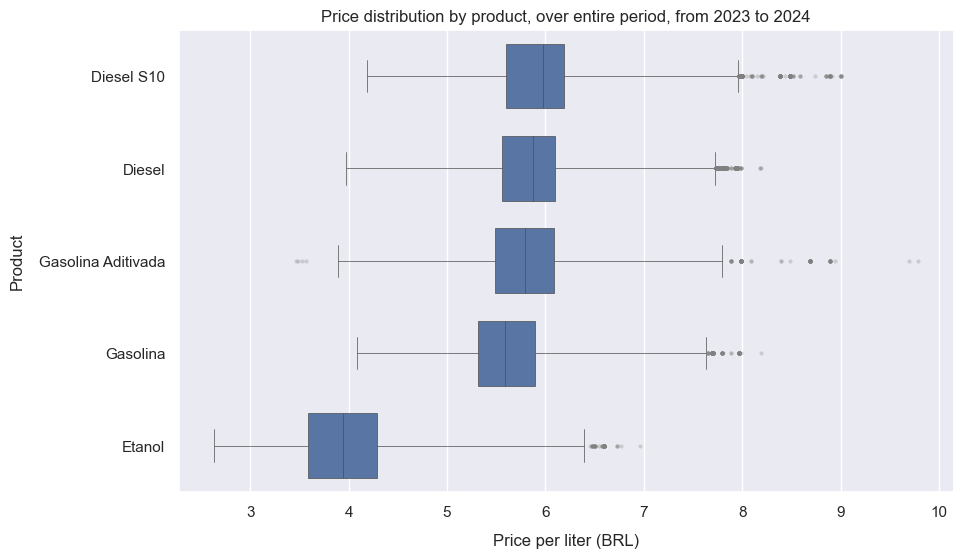

In [11]:
# Using the entire period
anp_products = anp[['product','price']]

sns.set_theme(style='darkgrid')
fig = plt.subplots(figsize=(10, 6))

# Define order by decreasing median
order_by_median = anp_products.groupby(by='product')['price'].median().sort_values(ascending=False).index

# Plot data
ax = sns.boxplot(data=anp_products, x='price', y='product',
            width=.7, linewidth=.5,
            whis=3, flierprops={'marker': '.', 'markeredgecolor':'none', 'markerfacecolor':'grey', 'alpha':0.3},
            order=order_by_median)

# Custom text based on period
period_text = np.array2string(anp['year'].min()) + ' to ' + np.array2string(anp['year'].max())

ax.set_title('Price distribution by product, over entire period, from ' + period_text)
ax.set_xlabel('Price per liter (BRL)', labelpad=10)
ax.set_ylabel('Product', labelpad=10)

plt.savefig('price_by_product.png', bbox_inches='tight', pad_inches=0.2);

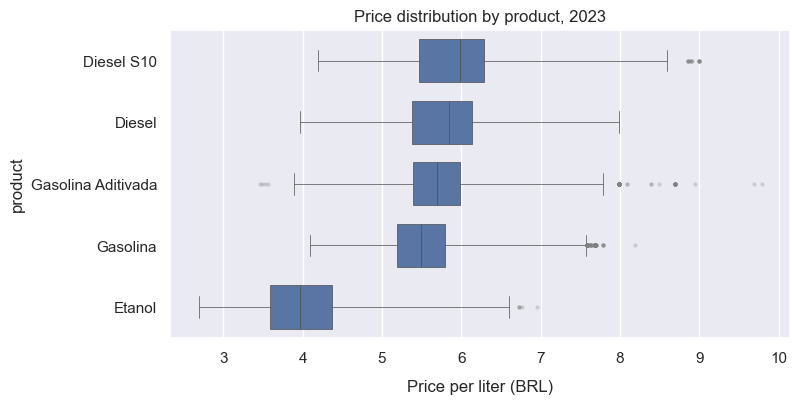

In [12]:
# Use first year

first_year = anp['year'].min()
first_year_mask = anp['year'] == first_year
anp_products_first_year = anp[first_year_mask]
anp_products = anp_products_first_year[['product','price']]

# Boxplot style
sns.set_theme(style='darkgrid')
fig = plt.subplots(figsize=(8, 4))

# Define order by decreasing median
order_by_median = anp_products.groupby(by='product')['price'].median().sort_values(ascending=False).index

# Plot data
ax = sns.boxplot(data=anp_products, x='price', y='product',
            width=.7, linewidth=.5,
            whis=3, flierprops={'marker': '.', 'markeredgecolor':'none', 'markerfacecolor':'grey', 'alpha':0.3},
            order=order_by_median)

# Custom text based on period
period_text = np.array2string(first_year)

ax.set_title('Price distribution by product, ' + period_text)
ax.set_xlabel('Price per liter (BRL)', labelpad=10);

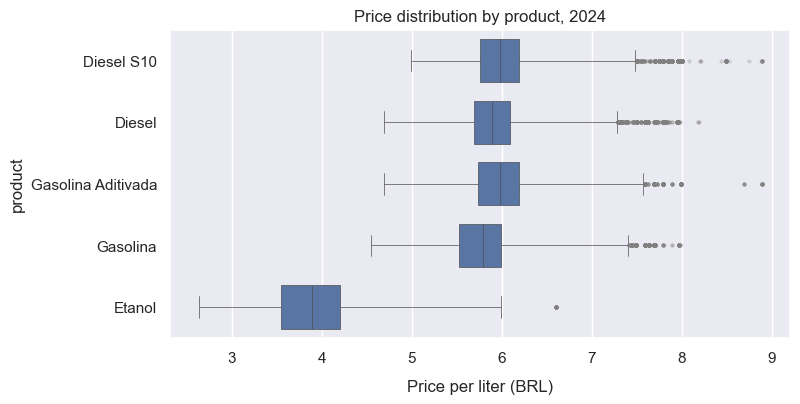

In [13]:
# Use last year

last_year = anp['year'].max()
last_year_mask = anp['year'] == last_year
anp_products_last_year = anp[last_year_mask]
anp_products = anp_products_last_year[['product','price']]

# Boxplot style
sns.set_theme(style='darkgrid')
fig = plt.subplots(figsize=(8, 4))

# Plot data
ax = sns.boxplot(data=anp_products, x='price', y='product',
            width=.7, linewidth=.5,
            whis=3, flierprops={'marker': '.', 'markeredgecolor':'none', 'markerfacecolor':'grey', 'alpha':0.3},
            order=order_by_median)

# Custom text based on period
period_text = np.array2string(last_year)

ax.set_title('Price distribution by product, ' + period_text)
ax.set_xlabel('Price per liter (BRL)', labelpad=10);

### Question 2:  Are there significant price differences between cities?

For this question we will focus on observing Normal and Added Gasoline

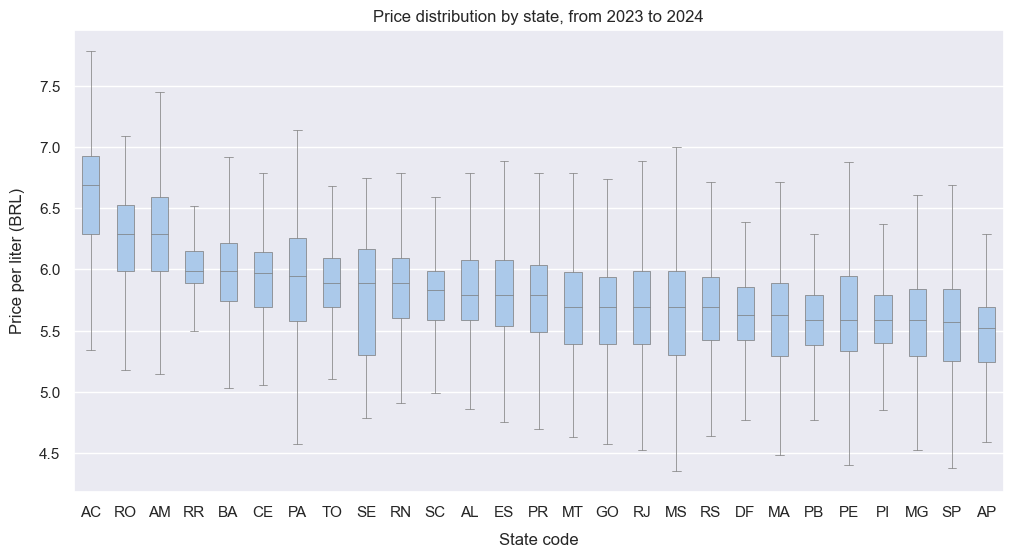

In [14]:
# Group by states

anp_states = anp_gas[['state_code','price']].sort_values(by='price', ascending = False)

# Boxplot style
sns.set_theme(style='darkgrid', palette='pastel')
fig = plt.subplots(figsize=(12, 6))

# Define order by decreasing median
order_by_median = anp_states.groupby(by='state_code')['price'].median().sort_values(ascending=False).index

# Plot data
ax = sns.boxplot(data=anp_states, x='state_code', y='price',
                 width=.5, linewidth=.5, showfliers=False,
                 order=order_by_median)

# Custom text based on period
period_text = np.array2string(anp['year'].min()) + ' to ' + np.array2string(anp['year'].max())

ax.set_title('Price distribution by state, from ' + period_text)
ax.set_xlabel('State code', labelpad=10)
ax.set_ylabel('Price per liter (BRL)', labelpad=10);

#### Assessing possible correlation between price and distance to refinery

##### Start by getting the geographic location of each city, based on another [Base dos Dados database](https://basedosdados.org/dataset/33b49786-fb5f-496f-bb7c-9811c985af8e?table=dffb65ac-9df9-4151-94bf-88c45bfcb056)

In [15]:
query_cities = '''
SELECT
    id_municipio,
    centroide
FROM `basedosdados.br_bd_diretorios_brasil.municipio` AS dados
'''

# Read query via 'Base dos dados' Google Cloud API
locations = bd.read_sql(query_cities, billing_project_id='anpec-base-dos-dados')

Downloading: 100%|█████████████████████████████████████████████████████████████| 5570/5570 [00:00<00:00, 6397.52rows/s]


In [16]:

# Translating column names
col_names_dict = {
    'id_municipio':'city_id',
    'centroide':'centroid',
}
locations = locations.rename(mapper = col_names_dict, axis=1)

# Preparing ANP dataset for merge
anp_cities = anp[['city_id','city_name']].drop_duplicates()

# Merge city locations with ANP dataset
cities_locations = pd.merge(
    left = anp_cities,
    right = locations,
    left_on = 'city_id',
    right_on = 'city_id',
    how = 'left'
)

cities_locations.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 461 entries, 0 to 460
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   city_id    461 non-null    object
 1   city_name  461 non-null    object
 2   centroid   461 non-null    object
dtypes: object(3)
memory usage: 14.4+ KB


In [17]:
# Extracting latitude from centroid
cities_locations['longitude'] = cities_locations['centroid'].str.split(pat=' ', expand=True)[0]
cities_locations['longitude'] = cities_locations['longitude'].str.replace(pat='POINT(', repl='', regex=False).astype('float')

# Extracting longitude from centroid
cities_locations['latitude'] = cities_locations['centroid'].str.split(pat=' ', expand=True)[1]
cities_locations['latitude'] = cities_locations['latitude'].str.replace(pat=')', repl='', regex=False).astype('float')

# Consolidate into coordinate tuple
cities_locations['coordinate'] = list(zip(cities_locations['latitude'], cities_locations['longitude']))
cities_locations = cities_locations.drop(['centroid', 'latitude', 'longitude'], axis=1)

# See first row as example
cities_locations.head(1)

,city_id,city_name,coordinate
0,3147105,Pará de Minas,"(-19.8342422509816, -44.6079149561075)"


**Note:** diffently than how coordinates are commonly formatted, GeoJSON Point dataype has "longitude, latitude" order.

##### Loading CSV file with coordinates from Brazil's refineries, manually consolidated through online search

In [18]:
# List of Brazil refineries extracted with ChatGPT and double check via Google Maps
brazil_refineries = pd.read_csv('brazil_refinery_list.csv')

latitude =  brazil_refineries['coordinates'].str.split(pat=',', expand=True)[0]
longitude =  brazil_refineries['coordinates'].str.split(pat=',', expand=True)[1]
brazil_refineries['coordinates'] = list(zip(latitude, longitude))

brazil_refineries

,refinery_name,coordinates,administration
0,REPLAN (Refinaria de Paulínia),"(-22.7294806, -47.1504445)",Petrobras
1,REFAP (Refinaria Alberto Pasqualini),"(-29.8698379, -51.1802307)",Petrobras
2,REPAR (Refinaria Presidente Getúlio Vargas),"(-27.6879564, -52.9121954)",Petrobras
3,Refinaria de Mataripe,"(-12.7048924, -38.5691808)",Others
4,REVAP (Refinaria Henrique Lage),"(-23.1845837, -45.8181446)",Petrobras
5,REGAP (Refinaria Gabriel Passos),"(-19.9636991, -44.0974502)",Petrobras
6,RPBC (Refinaria Presidente Bernardes),"(-23.8730057, -46.4377975)",Petrobras
7,LUBNOR (Lubrificantes e Derivados do Nordeste),"(-3.715116, -38.476465)",Petrobras
8,Rnest (Refinaria Abreu e Lima),"(-8.3768613, -35.0109399)",Petrobras
9,REAM (Refinaria Isaac Sabbá),"(-3.1435027, -59.9564067)",Others


##### Calculating distance from each city to closest refinery

In [19]:
import geopy.distance

In [20]:
def distancer(row: tuple) -> float:
    '''Finds the distance in km to the closest refinery, using geodesic distance

    Parameters
    ----------
    row : tuple
        The coordinate of cities centroid

    Returns
    -------
    float
        The nearer distance to any refinery listed in 'brazil_refineries' dataframe
    '''
    city_coordinate = row['coordinate']
    distance_list = []
    for i in brazil_refineries['coordinates']:
        distance = geopy.distance.distance(city_coordinate, i).km
        distance_list.append(distance)
    return min(distance_list)

cities_locations['nearer_refinery_distance'] = cities_locations.apply(distancer, axis=1)
cities_locations.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 461 entries, 0 to 460
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   city_id                   461 non-null    object 
 1   city_name                 461 non-null    object 
 2   coordinate                461 non-null    object 
 3   nearer_refinery_distance  461 non-null    float64
dtypes: float64(1), object(3)
memory usage: 18.0+ KB


**Note:** the function uses a geodesic method for calculating distances, from 'geopy' library. It is the distance on a curvature, considering that the Earth is not a perfect sphere (default:  WGS-84 ellipsoid). For a future improvement, it would be interesting to use a method that can take on considerating the path of roads, which would be closer to the transportation of gas from refinery to the city.

##### Plotting results

In [21]:
# Creating a dataframe with mean gas price, over 2023
anp_selection = anp[anp['product'].isin(['Gasolina','Gasolina Aditivada'])]
anp_selection = anp_selection[anp_selection['year'] == 2023]

anp_cities_mean = anp_selection[['city_name','price']] \
    .groupby('city_name').mean() \
    .reset_index()

# Merging to create a single dataframe with mean price and distance to nearest refinery
cities_price_distance = pd.merge(
    left = anp_cities_mean,
    right = cities_locations,
    left_on = 'city_name',
    right_on = 'city_name',
    how = 'inner'
)

In [22]:
import statsmodels.api as sm

x = cities_price_distance['nearer_refinery_distance']
y = cities_price_distance['price']

x = sm.add_constant(x)

result = sm.OLS(y, x).fit()

print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.124
Method:                 Least Squares   F-statistic:                     66.32
Date:                Tue, 01 Oct 2024   Prob (F-statistic):           3.65e-15
Time:                        23:11:56   Log-Likelihood:                -74.428
No. Observations:                 461   AIC:                             152.9
Df Residuals:                     459   BIC:                             161.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

**Note**: a constant variable is being added as it is fair to assume that gas has a fixed price, with an additional transportation cost.

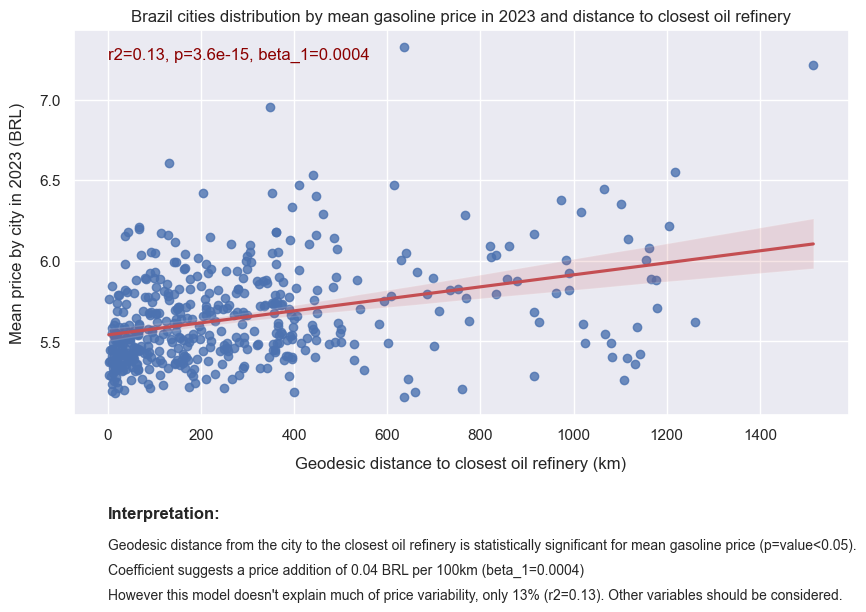

In [31]:
# Plotting results with scatter plot
sns.set_theme(style='darkgrid')
fig = plt.subplots(figsize=(10, 5))
ax = sns.regplot(data=cities_price_distance, x='nearer_refinery_distance', y='price', line_kws=dict(color="r"))

# Referencing regression results
beta_1 = result.params[1]
pvalue = result.pvalues[1]
rsquared = result.rsquared

# Styling plot
ax.set_title('Brazil cities distribution by mean gasoline price in 2023 and distance to closest oil refinery')
ax.set_ylabel('Mean price by city in 2023 (BRL)', labelpad=10)
ax.set_xlabel('Geodesic distance to closest oil refinery (km)', labelpad=10)

# Adding annotation with regression results
ax.text(0, 7.25, f'r2={rsquared:.2f}, p={pvalue:.2g}, beta_1={beta_1:.4f}',
        transform=ax.transData, color='darkred', fontsize='medium')

ax.text(0, 4.4, "Interpretation:", transform=ax.transData, fontweight='bold', fontsize='medium')
ax.text(0, 3.9, "Geodesic distance from the city to the closest oil refinery is statistically significant for mean gasoline price (p=value<0.05).\nCoefficient suggests a price addition of 0.04 BRL per 100km (beta_1=0.0004)\nHowever this model doesn't explain much of price variability, only 13% (r2=0.13). Other variables should be considered.",
        transform=ax.transData, fontsize='small', linespacing=2)

plt.savefig('distance_regression.png', bbox_inches='tight', pad_inches=0.2);

##### **Results interpretation:**
The predictor variable (geodesic distance to closest oil refinery) is statistically significant, as indicated by the p-value below 0.05. However the model does not explain much of the variability in the response variable, as indicated by the R-squared value only 15% of its variance is explained. There are other important variables no included in the model.

### Question 3: which external factors can have correlation with gas prices?

Correlação com a guerra russa e ucrânia
correlação com as eleições no Brasil (fazer janelas)

In [24]:
# SQL query

query_anp = '''
SELECT
  data_coleta,
  preco_venda,
FROM `basedosdados.br_anp_precos_combustiveis.microdados` AS dados
WHERE (dados.data_coleta > '2021-06-30' AND dados.data_coleta < '2024-07-01')
AND dados.produto IN ('Gasolina','Gasolina Aditivada')
ORDER BY dados.data_coleta
'''

# Read query via 'Base dos dados' Google Cloud API
anp_L3Y = bd.read_sql(query_anp, billing_project_id='anpec-base-dos-dados')

Downloading: 100%|██████████████████████████████████████████████████████| 1213680/1213680 [00:38<00:00, 31427.42rows/s]


In [25]:
# Rename columns
col_names_dict = {
    'data_coleta':'observation_date',
    'preco_venda':'price'
}
anp_L3Y = anp_L3Y.rename(mapper = col_names_dict, axis=1)

# Defining datatypes
data_types_dict = {
    'observation_date':'datetime64[ns]'
}
anp_L3Y = anp_L3Y.astype(data_types_dict)

anp_L3Y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1213680 entries, 0 to 1213679
Data columns (total 2 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   observation_date  1213680 non-null  datetime64[ns]
 1   price             1213680 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 18.5 MB


In [26]:
import yfinance as yf

In [27]:
# CL=F is the ticker for West Texas Intermediate (WTI) Crude Oil futures

oil = 'CL=F'
start_date = '2021-06-30'
end_date = '2024-06-30'

oil_data_L3Y = yf.download(oil, start=start_date, end=end_date).reset_index()
oil_data_L3Y.info()

[*********************100%***********************]  1 of 1 completed

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 754 entries, 0 to 753
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       754 non-null    datetime64[ns]
 1   Open       754 non-null    float64       
 2   High       754 non-null    float64       
 3   Low        754 non-null    float64       
 4   Close      754 non-null    float64       
 5   Adj Close  754 non-null    float64       
 6   Volume     754 non-null    int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 41.4 KB


**Note**: there are many ways to reference crude oil prices, in this case the benchmark being used is West Texas Intermediate (WTI), traded through future options.

In [28]:
# Creating dataframe with mean gas price in Brazil for each observed date
anp_gas_mean_L3Y = pd.DataFrame(anp_L3Y[['observation_date','price']].groupby(by='observation_date')['price'].mean()).reset_index()

# Merge gas prices and crude oil open price
oil_vs_gas_L3Y = pd.merge(
    left = oil_data_L3Y,
    right = anp_gas_mean_L3Y,
    left_on = 'Date',
    right_on = 'observation_date',
    how = 'left'
)

oil_vs_gas_L3Y = oil_vs_gas_L3Y[['Date','price','Open']]

col_names_dict = {
    'Date':'date',
    'price':'Brazil gas prices',
    'Open':'Crude oil price',
}

oil_vs_gas_L3Y = oil_vs_gas_L3Y.rename(mapper = col_names_dict, axis=1)

oil_vs_gas_L3Y.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 754 entries, 0 to 753
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date               754 non-null    datetime64[ns]
 1   Brazil gas prices  721 non-null    float64       
 2   Crude oil price    754 non-null    float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 23.6 KB


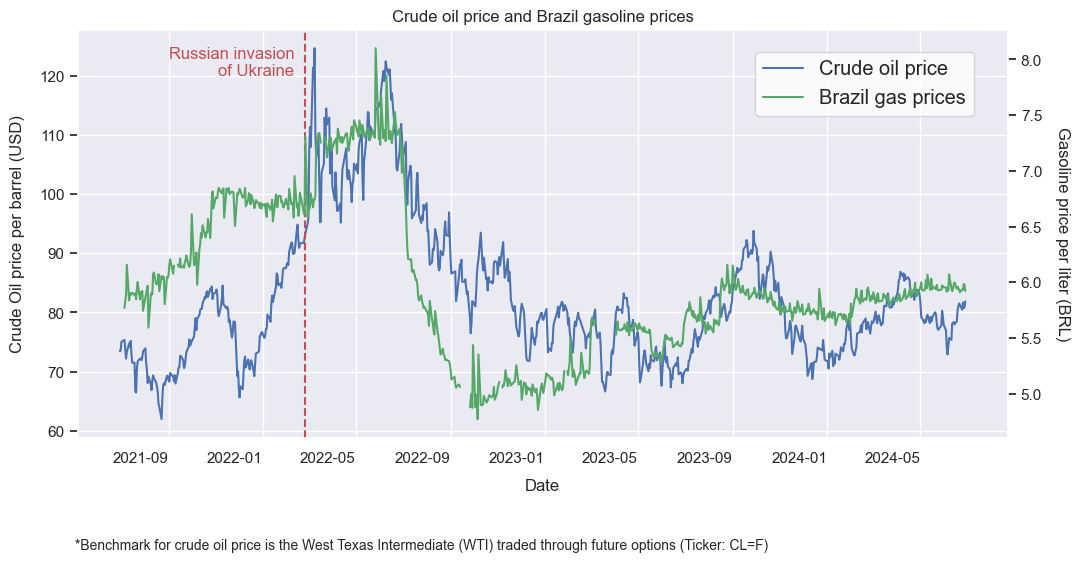

In [34]:
plt.rcParams['figure.figsize'] = [12, 6]

# Plotting two axis comparing gas prices and crude oil price
ax = oil_vs_gas_L3Y.plot(x='date', y='Crude oil price', legend=False)
ax2 = ax.twinx()
oil_vs_gas_L3Y.plot(x='date', y='Brazil gas prices', ax=ax2, color='g', legend=False)

# Labels and ticks styling
ax.set_xlabel('Date', labelpad=10)
ax.set_ylabel('Crude Oil price per barrel (USD)', labelpad=10)
ax2.set_ylabel('Gasoline price per liter (BRL)',rotation=270, labelpad=20)
ax.tick_params(axis='x', rotation=0)

# Legend and title
ax.figure.legend(loc='upper right', bbox_to_anchor=(0.88, 0.86), fontsize='large', facecolor='white')
ax.set_title('Crude oil price and Brazil gasoline prices')

# Annotation to mark possible cause of spike in the period
ax.text('2021-09-01',120,'Russian invasion\nof Ukraine', multialignment='right', color='r')
ax.axvline('2022-02-24', ls='--', color='r')

ax.text(18750, 40, "*Benchmark for crude oil price is the West Texas Intermediate (WTI) traded through future options (Ticker: CL=F)",
        transform=ax.transData, fontsize='small')

plt.grid(False)

plt.savefig('oil_gas_timeseries.png', bbox_inches='tight', pad_inches=0.2);

### Additional analysis: impact of floods in Rio Grande do Sul (supply chain disruption)

In June of 2024, the southern state in Brazil, Rio Grande do Sul (RS) was heavily impacted by extreme weather events such as floods. This has caused a relevent interruption in transportation inside the state, has many roads where blocked. The following chart compares weely mean gasoline prices by cities dividing into 2 groups: least affected cities (below 20% of area affected) and highly affected cities (20% or more of area affected). Based on [study by NGO MapBiomas](https://brasil.mapbiomas.org/2024/06/10/dois-tercos-dos-municipios-do-rio-grande-do-sul-foram-afetados-pelos-eventos-extremos-deste-ano/).
<br>
<br>Results don't show a clear impact of floods in gas prices, as price movements follow overall Brazil trend. Some possible reasons are price regulation from governamental agency.

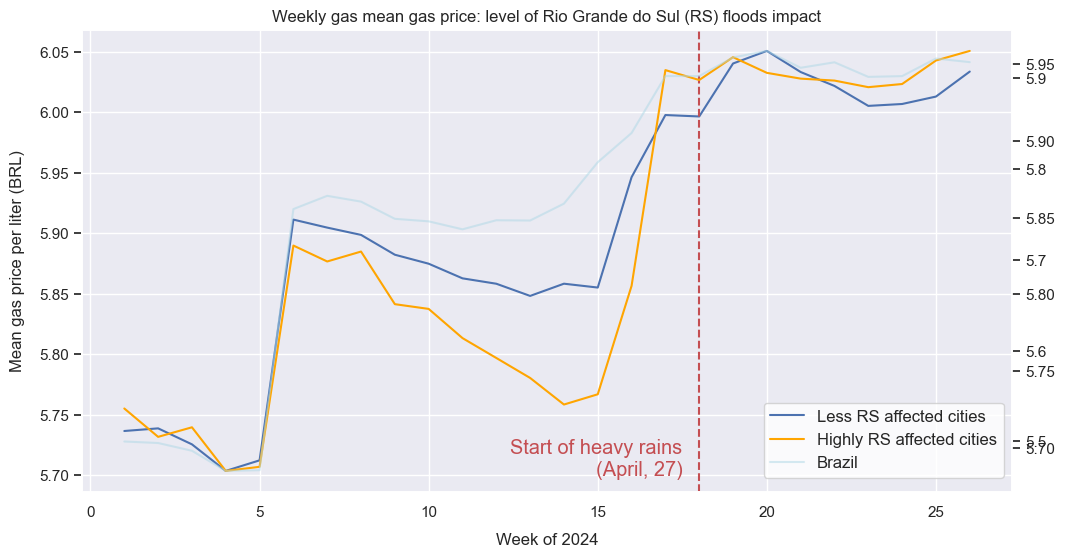

In [30]:
# Filtering dataframes
anp_2024 = anp_gas[anp_gas['year'] == 2024]
anp_2024_RS = anp_2024[anp_2024['state_code'] == 'RS']

# Creating two groups based on flood impact
impacted_list = ['Nova Santa Rita','Esteio','Charqueadas','Canoas','São Leopoldo','Porto Alegre','Rio Grande']
anp_2024_RS_notimpacted = anp_2024_RS[~anp_2024['city_name'].isin(impacted_list)]
anp_2024_RS_impacted = anp_2024_RS[anp_2024['city_name'].isin(impacted_list)]

# Creating groupby dataframes to be plotted
notimpacted_weekly_mean = pd.DataFrame(anp_2024_RS_notimpacted.groupby(by=['week_number'])['price'].mean()).reset_index()
impacted_weekly_mean = pd.DataFrame(anp_2024_RS_impacted.groupby(by=['week_number'])['price'].mean()).reset_index()

# Axis 1 = Less affected cities
ax = notimpacted_weekly_mean.plot(x='week_number', y='price', legend=False)

# Axis 2 = Highly affected cities
ax2 = ax.twinx()
impacted_weekly_mean.plot(x='week_number', y='price', ax=ax2, color='orange', legend=False)
ax2.grid(False)

# Axis 3 = Brazil overall to be used as a benchmark
ax3 = ax.twinx()
brazil_weekly_mean = pd.DataFrame(anp_2024.groupby(by=['week_number'])['price'].mean()).reset_index()
brazil_weekly_mean.plot(x='week_number', y='price', ax=ax3, color='lightblue', legend=False, alpha=0.5)
ax3.grid(False)

# Stilying
ax.set_xlabel('Week of 2024', labelpad=10)
ax.set_ylabel('Mean gas price per liter (BRL)', labelpad=10)
ax.figure.legend(['Less RS affected cities', 'Highly RS affected cities','Brazil'],loc='lower right', bbox_to_anchor=(0.9, 0.12), fontsize='medium', facecolor='white')
ax.set_title('Weekly gas mean gas price: level of Rio Grande do Sul (RS) floods impact')
ax.text(17.5, 5.7, "Start of heavy rains\n(April, 27)", transform=ax.transData, color='r', ha='right', fontsize='large')
ax.axvline(18, ls='--', color='r')

plt.show()